# Draw the ROC Curves from the outputs of the model

Based on: https://github.com/hqucms/dl4hep/blob/MITP2023/4_particle_net.ipynb

Import relevant modules:

In [1]:
import os
import numpy as np
import awkward as ak
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import vector
vector.register_awkward()


from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.interpolate import interp1d


Extract the predicted labels into pandas dataframe

In [2]:
def compute_metrics(y_true, probs):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=probs[:, 1])
    auc_test = auc(fpr, tpr)
    acc_test = accuracy_score(y_true, probs.argmax(1))
    background_eff_fn = interp1d(tpr, fpr)
    background_eff_at_50 = background_eff_fn(0.7)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(f"Backround rejection at 50% signal efficiency: {1/background_eff_at_50:.0f}")
    return fpr, tpr

def metrics(f1,f2):
        #open the root files and convert to pandas
        df_test_signal = uproot.open(f1)["Events"].arrays(library="pd")
        df_test_background = uproot.open(f2)["Events"].arrays(library="pd")
        df_test = pd.concat([df_test_signal, df_test_background])
        # Truth label: ll =1, tt =0
        y_true = df_test["label_ll"]
        # output of the neural network
        prediction_probs = df_test[["score_label_ll", "score_label_tt"]].values

        #plot the number of occurences of the neural network output
        plt.figure()
        plt.hist([1- prediction_probs[y_true == 1, 1], 1- prediction_probs[y_true == 0, 1]],
                label=["ll", "tt"], bins=50, histtype="step", density=True)
        plt.xlabel("Neural Network output")
        plt.xlim(0, 1)
        plt.legend()
        plt.show()

        #plot the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=1-prediction_probs[:, 1])
        auc_test = auc(fpr, tpr)

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"ll (AUC={auc_test:.4f})")
        plt.plot([0, 1], [0, 1], ls="--", color="k")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.legend()
        plt.show()

        #print the metrics
        compute_metrics(y_true, 1- prediction_probs)

Visualize the Occurance of different Network-Outputs.

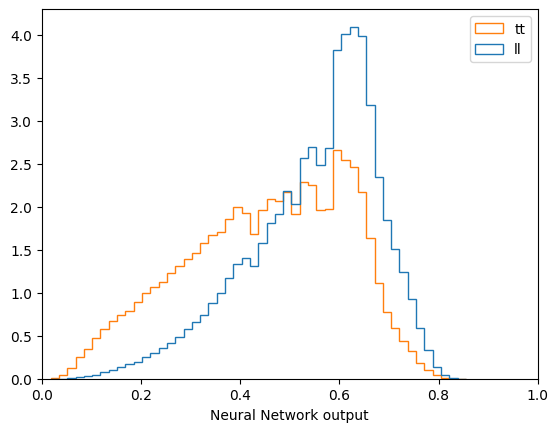

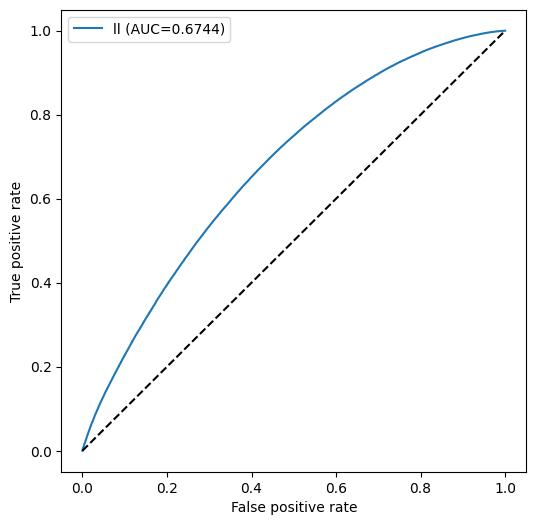

Accuracy: 0.6266
AUC: 0.6744
Backround rejection at 50% signal efficiency: 2


In [3]:
metrics("/work/larshust/VBS/particle_transformer/predict_output/pred_PFN_2e-2_1500k_ll.root", "/work/larshust/VBS/particle_transformer/predict_output/pred_PFN_2e-2_1500k_tt.root")

In [4]:
def metrics_sbs(f1, f2):
    # Open the root files and convert to pandas
    df_test_signal = uproot.open(f1)["Events"].arrays(library="pd")
    df_test_background = uproot.open(f2)["Events"].arrays(library="pd")
    df_test = pd.concat([df_test_signal, df_test_background])
    # Truth label: ll = 1, tt = 0
    y_true = df_test["label_ll"]
    # Output of the neural network
    prediction_probs = df_test[["score_label_ll", "score_label_tt"]].values

    # Plot the number of occurrences of the neural network output
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    #make title and subtitles
    fig.suptitle("ParT", fontsize=16)

    axs[0].set_title("Neural Network output")

    axs[0].hist([1 - prediction_probs[y_true == 1, 1], 1 - prediction_probs[y_true == 0, 1]],
                label=["ll", "tt"], bins=50, histtype="step", density=True)
    axs[0].set_xlabel("Neural Network output")
    axs[0].set_xlim(0, 1)
    axs[0].legend()

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=1 - prediction_probs[:, 1])
    auc_test = auc(fpr, tpr)

    axs[1].set_title("ROC curve")
    axs[1].plot(fpr, tpr, label=f"ll (AUC={auc_test:.4f})")
    axs[1].plot([0, 1], [0, 1], ls="--", color="k")
    axs[1].set_xlabel("False positive rate")
    axs[1].set_ylabel("True positive rate")
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()

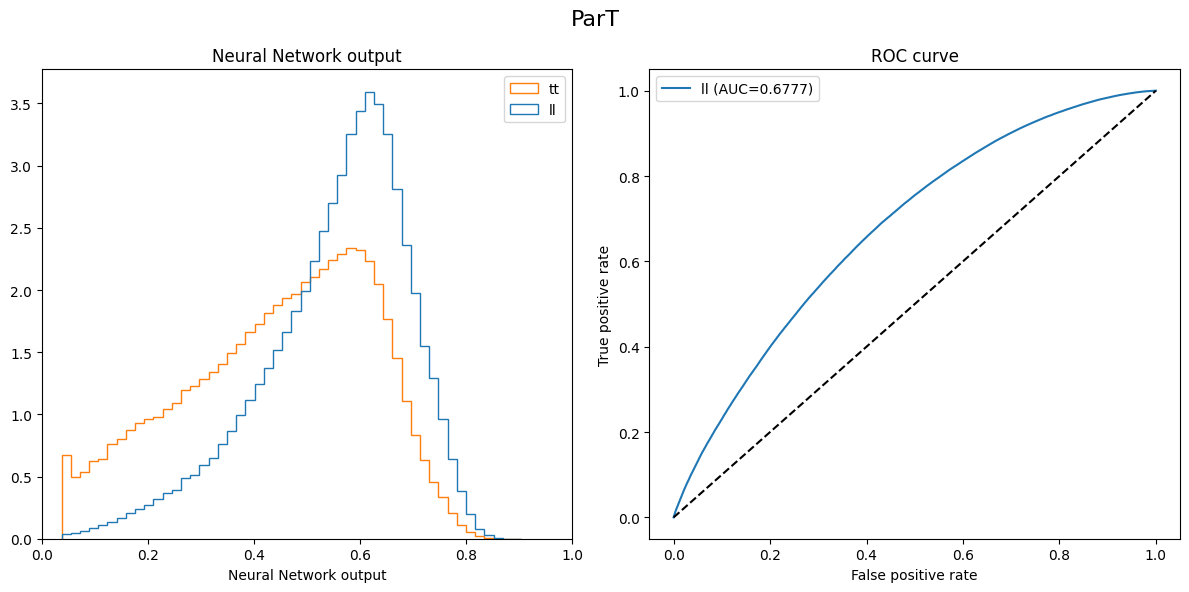

In [5]:
metrics_sbs("/work/larshust/VBS/particle_transformer/predict_output/pred_ParT_1e-3_1500k_ll.root", "/work/larshust/VBS/particle_transformer/predict_output/pred_ParT_1e-3_1500k_tt.root")